## Setup

In [ ]:
!pip install audiomentations

In [30]:
import kagglehub
import shutil
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [33]:
# Download all 4 datasets
path = kagglehub.dataset_download("dmitrybabko/speech-emotion-recognition-en")
data_path = "/content/datasets"
shutil.copytree(path, data_path)

In [34]:
# Set global sample rate
SAMPLE_RATE = 16000

## Helper functions

In [40]:
# Helper function for plotting duration histograms for the audio clips
def plot_audio_lengths(audio_lengths):
  # Get clip durations in seconds
  durations = (audio_lengths / SAMPLE_RATE)
  durations.name = "clip durations"
  display(durations.describe().to_frame().T)

  fig, ax = plt.subplots(1, 2, figsize=(12, 5))

  # Plot histogram of sample lengths
  sns.histplot(data=audio_lengths, kde=True, ax=ax[0])
  ax[0].set_title("Audio clip samples")

  # Plot histogram of durations (in seconds)
  sns.histplot(data=(audio_lengths / SAMPLE_RATE), kde=True, ax=ax[1])
  ax[1].set_title("Audio clip duration (seconds)")

  plt.tight_layout()
  plt.show()

In [41]:
# Helper function for sampling and plotting waveforms for each emotion
def take_audio_samples(df):
  for emotion in df["emotion"].unique():
    # Take a sample for this emotion, plot the waveform and play the audio
    sample = df[df["emotion"] == emotion].sample(n=1)

    print(f"{emotion} sample:")
    waveform = sample.iloc[0]["waveform"]
    time_axis = torch.arange(0, len(waveform[0])) / SAMPLE_RATE
    plt.figure(figsize=(12, 3))
    plt.plot(time_axis, waveform[0].numpy())
    plt.xlabel("duration (s)")
    plt.ylabel("amplitude")
    plt.show()

    # Show audio player
    audio = Audio(data=waveform[0].numpy(), rate=SAMPLE_RATE)
    display(audio)
    print("\n")

In [42]:
# Helper function to trim trailing and leading silence
def trim_silence(waveform, cutoff, criteria="mean"):
  assert criteria in ("mean", "percentile")
  # Find where waveform is above threshold using mean thresholding
  if criteria == "mean":
    mean_energy = np.mean(np.abs(waveform))
    threshold = mean_energy * cutoff
  # Find where waveform is above threshold using percentile thresholding
  if criteria == "percentile":
    threshold = np.percentile(np.abs(waveform), cutoff)
  above_threshold = np.abs(waveform) > threshold

  # Compute start and end indices for trimming
  if np.any(above_threshold):
    start_idx = np.argmax(above_threshold)
    end_idx = len(above_threshold) - np.argmax(above_threshold[::-1])
  else:
    start_idx, end_idx = 0, len(waveform)

  # Trim the waveform
  trimmed = waveform[start_idx:end_idx]
  trimmed = torch.tensor(trimmed).unsqueeze(0)
  return trimmed

In [43]:
# Helper function for testing silence trimming
def test_trim(waveform, cutoff, criteria="mean"):
  assert criteria in ("mean", "percentile")
  # Find where waveform is above threshold
  if criteria == "mean":
    threshold = np.mean(np.abs(waveform)) * cutoff
  if criteria == "percentile":
    threshold = np.percentile(np.abs(waveform), cutoff)
  above_threshold = np.abs(waveform) > threshold

  # Find first and last non-silent indices
  if np.any(above_threshold):
      start_idx = np.argmax(above_threshold)  # first True
      end_idx = len(above_threshold) - np.argmax(above_threshold[::-1])  # last True
  else:
      start_idx, end_idx = 0, len(waveform)

  # Trim waveform
  trimmed_waveform = waveform[start_idx:end_idx]

  # Plot
  plt.figure(figsize=(12, 4))
  time_axis = torch.arange(0, len(waveform)) / SAMPLE_RATE
  plt.plot(time_axis, waveform, color='gray', label='Waveform')

  # Convert start and end indices into time (seconds)
  start_time = start_idx / SAMPLE_RATE
  end_time = end_idx / SAMPLE_RATE
  total_time = len(waveform) / SAMPLE_RATE

  plt.axvspan(0, start_time, color='red', alpha=0.5, label='leading silence')
  plt.axvspan(end_time, total_time, color='red', alpha=0.5, label='trailing silence')

  plt.title('waveform with leading and trailing silence highlighted')
  plt.xlabel('duration (s)')
  plt.ylabel('amplitude')
  plt.legend()
  plt.show()


  # Play original waveform
  print("Original Audio:")
  display(Audio(waveform, rate=SAMPLE_RATE))

  # Play trimmed waveform
  print("Trimmed Audio:")
  display(Audio(trimmed_waveform, rate=SAMPLE_RATE))

In [44]:
# Helper function for splitting waveform in half
def split_waveform(waveform):
  split_index = waveform.shape[1] // 2
  first_half = waveform[:, :split_index]
  second_half = waveform[:, split_index:]
  return [first_half, second_half]

## Datasets

### CREMA-D

In [45]:
# Read data from CREMA-D directory
crema_dir = "/content/datasets/Crema"
crema_data = []
label_map = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fearful",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad"
}

# For every audio file, parse metadata from the filename and load waveform
for file in os.listdir(crema_dir):
  # Metadata
  parts = file.split("_")
  sentence = parts[1]
  label = label_map[parts[2]]

  # Waveform
  file_path = os.path.join(crema_dir, file)
  waveform, sample_rate = torchaudio.load(file_path)

  # Assemble row of data
  crema_data.append({
    "file_path": file_path,
    "emotion": label,
    "sentence_type": sentence,
    "waveform": waveform,
    "length": waveform.shape[1]
  })

# Create dataframe
crema_df = pd.DataFrame(data=crema_data)
print(crema_df.info())
crema_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   file_path      7442 non-null   object
 1   emotion        7442 non-null   object
 2   sentence_type  7442 non-null   object
 3   waveform       7442 non-null   object
 4   length         7442 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 290.8+ KB
None


file_path  emotion sentence_type  \
0  /content/datasets/Crema/1018_IWL_NEU_XX.wav  neutral           IWL   
1  /content/datasets/Crema/1081_WSI_NEU_XX.wav  neutral           WSI   
2  /content/datasets/Crema/1058_ITS_NEU_XX.wav  neutral           ITS   
3  /content/datasets/Crema/1011_IEO_ANG_HI.wav    angry           IEO   
4  /content/datasets/Crema/1053_DFA_SAD_XX.wav      sad           DFA   

                                            waveform  length  
0  [[tensor(0.0033), tensor(0.0029), tensor(0.003...   32032  
1  [[tensor(0.0094), tensor(0.0095), tensor(0.009...   44845  
2  [[tensor(-0.0004), tensor(9.1553e-05), tensor(...   46446  
3  [[tensor(0.0012), tensor(0.), tensor(-0.0010),...   54988  
4  [[tensor(-0.0040), tensor(-0.0048), tensor(-0....   30430

emotion  angry   sad  happy  disgust  fearful  neutral
count     1271  1271   1271     1271     1271     1087

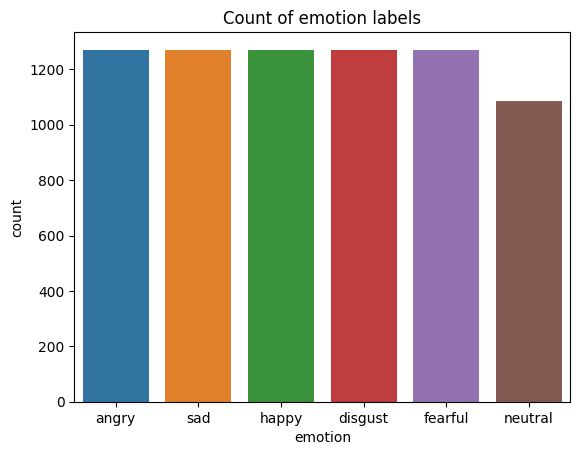

In [13]:
# View distribution of emotion labels
display(crema_df["emotion"].value_counts().to_frame().T)

sns.barplot(
    data=crema_df["emotion"].value_counts().reset_index(),
    x="emotion",
    y="count",
    hue="emotion"
)

plt.title("Count of emotion labels")
plt.show()

count      mean       std       min       25%     50%  \
clip durations  7442.0  2.542884  0.505979  1.267937  2.202187  2.5025   

                     75%    max  
clip durations  2.836187  5.005

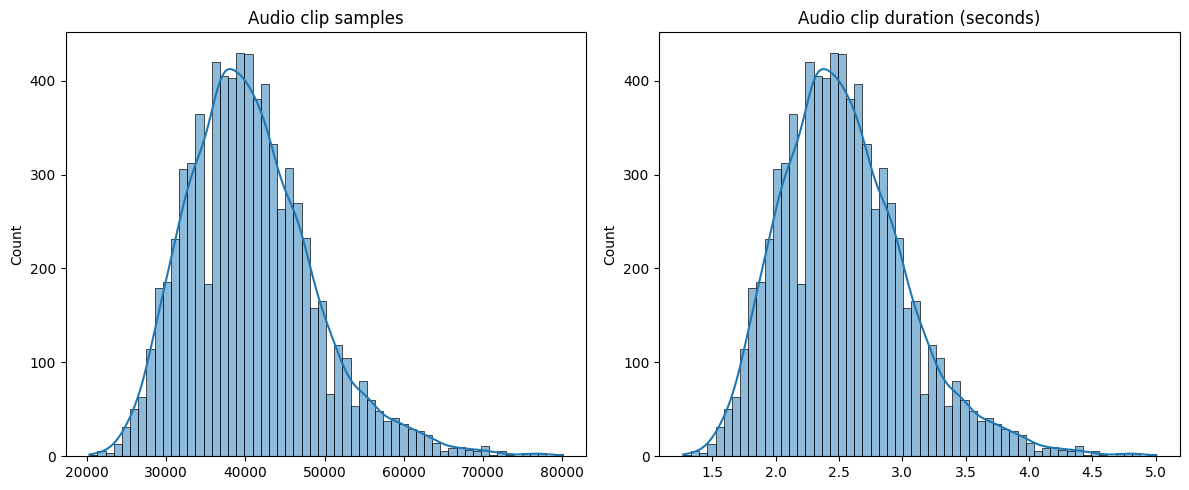

In [ ]:
# Examine distribution of clip lengths
audio_lengths = crema_df.apply(lambda a: a['waveform'].shape[1], axis=1)
plot_audio_lengths(audio_lengths)

disgust sample:


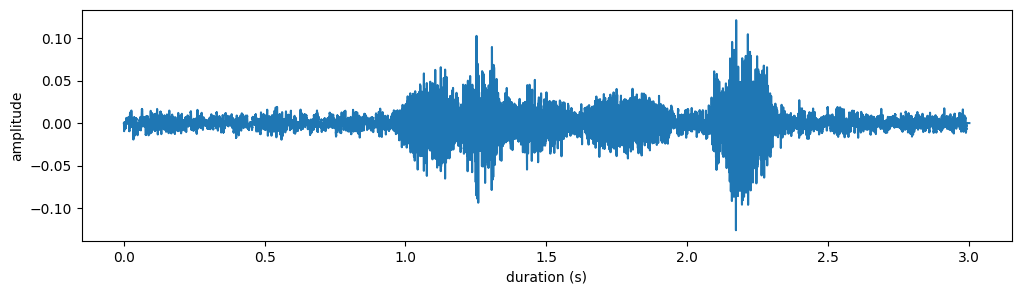



angry sample:


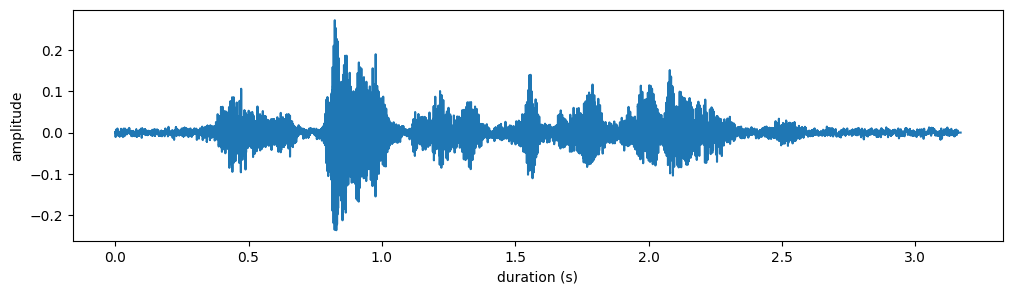



sad sample:


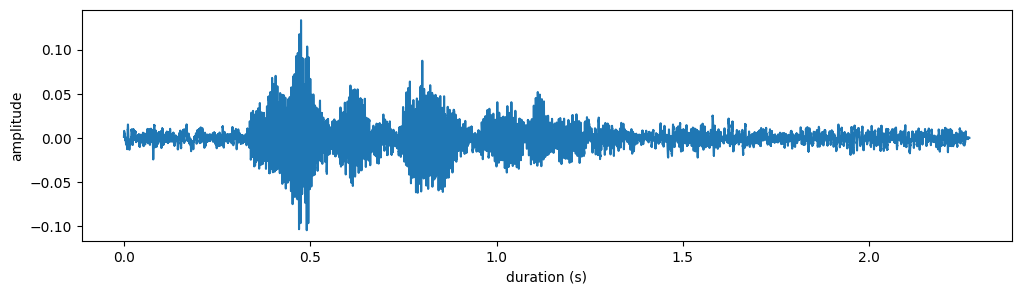



happy sample:


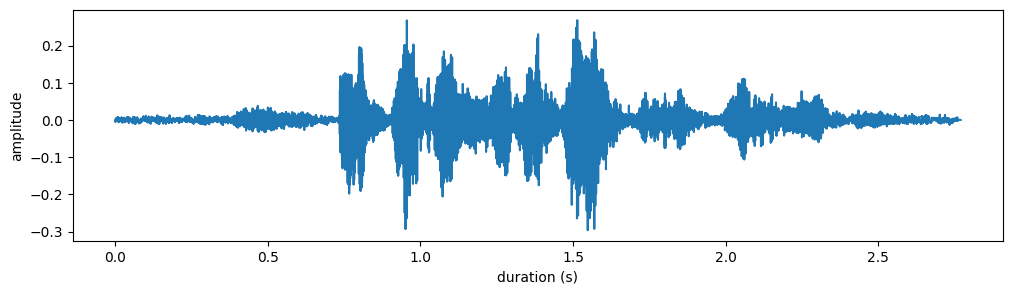



fearful sample:


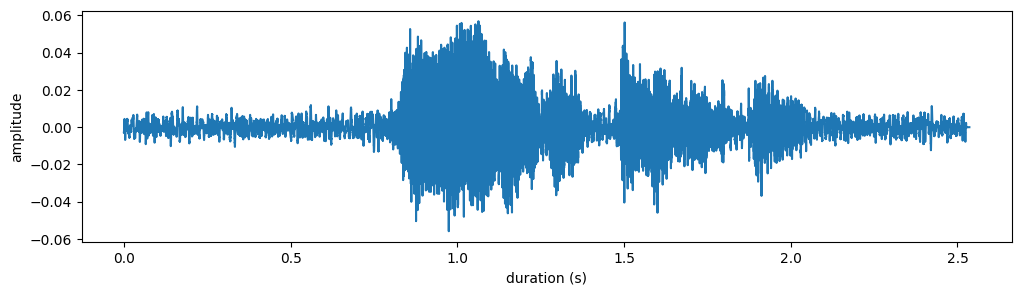



neutral sample:


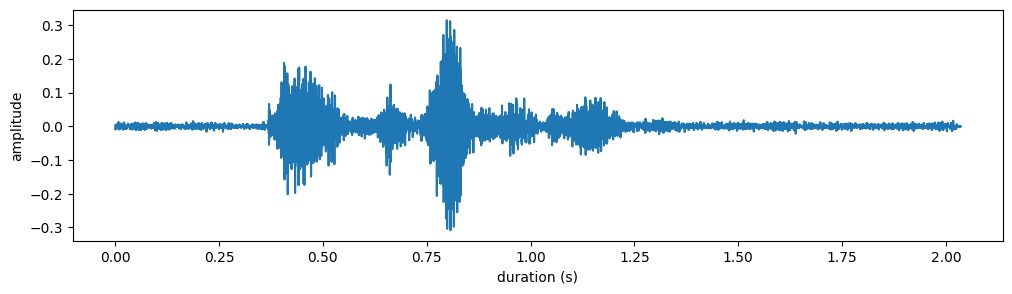

In [ ]:
# Plot a sample waveform for each emotion
take_audio_samples(crema_df)

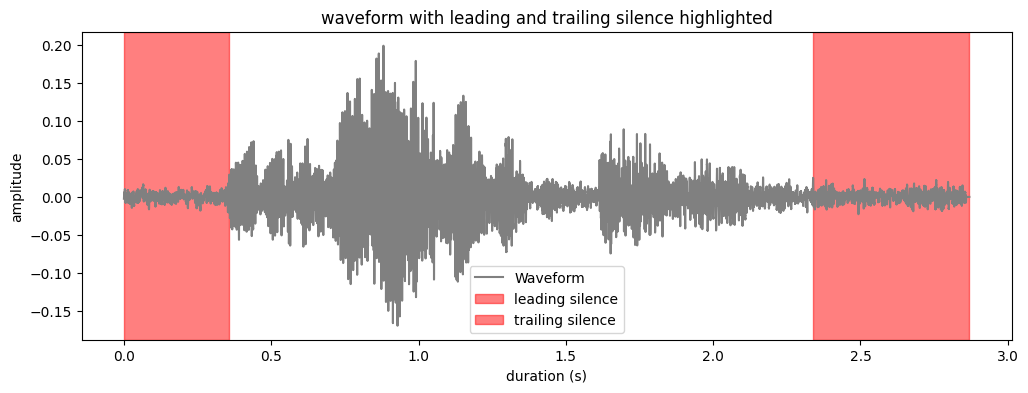

Original Audio:


Trimmed Audio:


In [ ]:
# Find where waveform is above threshold
sample = crema_df.sample(n=1).iloc[0]
waveform = sample["waveform"][0].numpy()
test_trim(waveform, 80, criteria="percentile")

In [ ]:
# crema_df["waveform"] = crema_df["waveform"].apply(lambda a: trim_silence(a[0].numpy(), 80, criteria="percentile"))

count      mean       std       min       25%       50%  \
clip durations  7442.0  1.290834  0.475386  0.252625  0.969266  1.215375   

                     75%       max  
clip durations  1.505937  4.965625

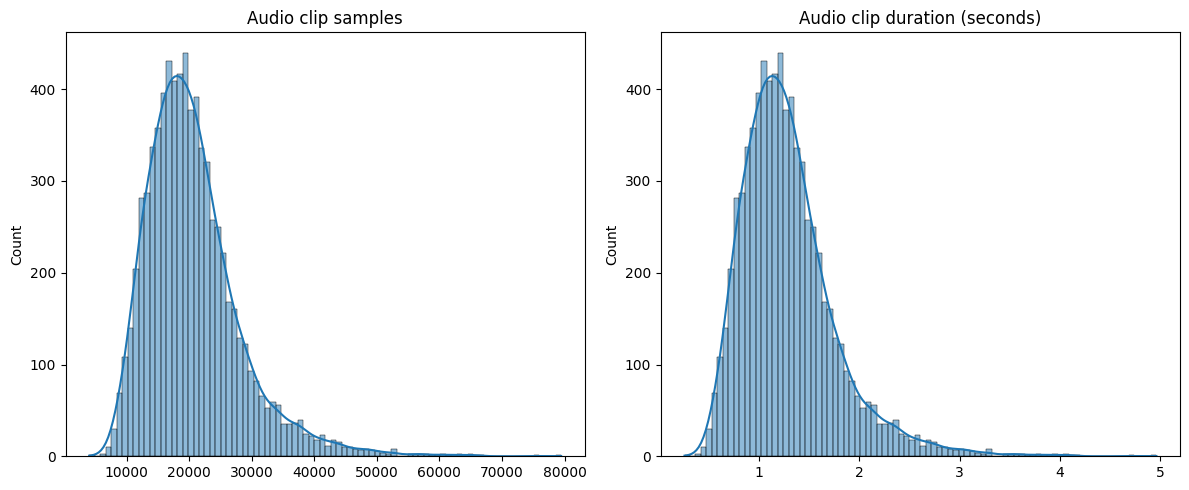

In [ ]:
# Examine distribution of clip lengths
audio_lengths = crema_df.apply(lambda a: a['waveform'].shape[1], axis=1)
plot_audio_lengths(audio_lengths)

### RAVDESS

In [46]:
ravdess_dir = "/content/datasets/Ravdess/audio_speech_actors_01-24"

# Set sample rate to 16 kHz
resample = torchaudio.transforms.Resample(orig_freq=48000, new_freq=SAMPLE_RATE)

# Prepare a list to hold data
ravdess_data = []

# Labels for metadata decoding
label_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Walk through each actor folder
for actor_id in range(1, 25):
  actor_path = os.path.join(ravdess_dir, f"Actor_{actor_id:02d}")
  for file in os.listdir(actor_path):
    parts = file.split("-")
    emotion = label_map[parts[2]]
    file_path = os.path.join(actor_path, file)

    waveform, sample_rate = torchaudio.load(file_path)
    # Downsample to 16 kHz
    waveform = resample(waveform)
    if waveform.shape[0] > 1:
      waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Assemble row of data
    ravdess_data.append({
      "file_path": file_path,
      "emotion": emotion,
      "waveform": waveform,
      "length": waveform.shape[1]
    })

# Create dataframe
ravdess_df = pd.DataFrame(data=ravdess_data)
print(ravdess_df.info())
ravdess_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  1440 non-null   object
 1   emotion    1440 non-null   object
 2   waveform   1440 non-null   object
 3   length     1440 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 45.1+ KB
None


file_path    emotion  \
0  /content/datasets/Ravdess/audio_speech_actors_...    fearful   
1  /content/datasets/Ravdess/audio_speech_actors_...  surprised   
2  /content/datasets/Ravdess/audio_speech_actors_...      happy   
3  /content/datasets/Ravdess/audio_speech_actors_...    disgust   
4  /content/datasets/Ravdess/audio_speech_actors_...       calm   

                                            waveform  length  
0  [[tensor(4.1488e-06), tensor(1.8465e-05), tens...   58726  
1  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...   54988  
2  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...   62997  
3  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...   68869  
4  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...   64064

emotion  fearful  surprised  happy  disgust  calm  sad  angry  neutral
count        192        192    192      192   192  192    192       96

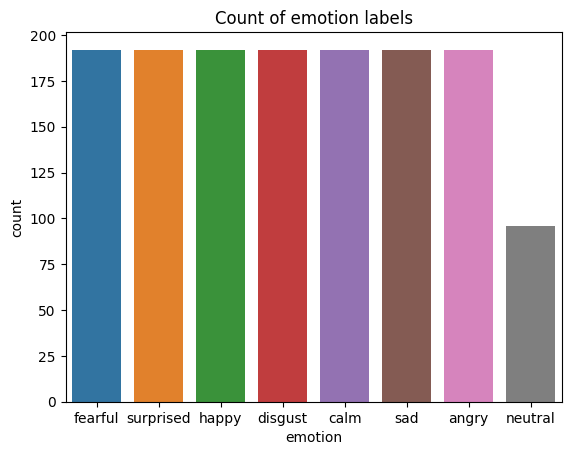

In [47]:
# View distribution of emotion labels
display(ravdess_df["emotion"].value_counts().to_frame().T)

sns.barplot(
    data=ravdess_df["emotion"].value_counts().reset_index(),
    x="emotion",
    y="count",
    hue="emotion"
)

plt.title("Count of emotion labels")
plt.show()

In [48]:
# Collapse calm and neutral into one category
ravdess_df['emotion'] = ravdess_df['emotion'].replace({'calm': 'neutral'})
display(ravdess_df['emotion'].value_counts().to_frame().T)

emotion  neutral  surprised  fearful  happy  disgust  sad  angry
count        288        192      192    192      192  192    192

count      mean       std       min       25%       50%  \
clip durations  1440.0  3.700685  0.336675  2.936313  3.470188  3.670375   

                     75%       max  
clip durations  3.870563  5.271937

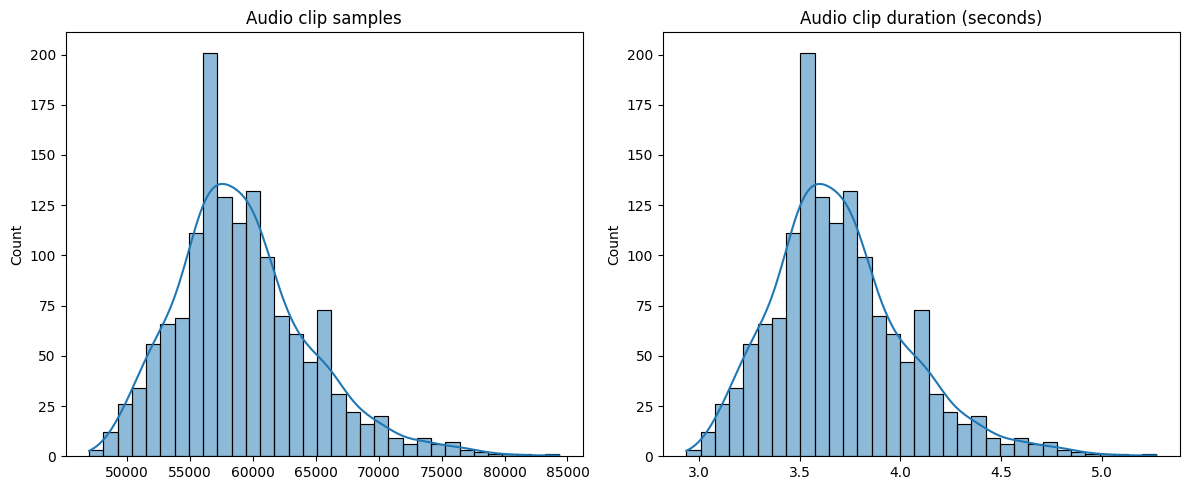

In [ ]:
# Examine distribution of clip lengths
audio_lengths = ravdess_df.apply(lambda a: a["waveform"].shape[1], axis=1)
plot_audio_lengths(audio_lengths)

angry sample:


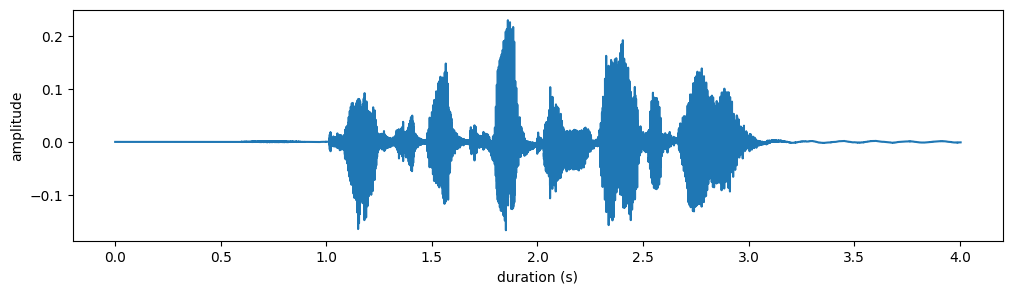



surprised sample:


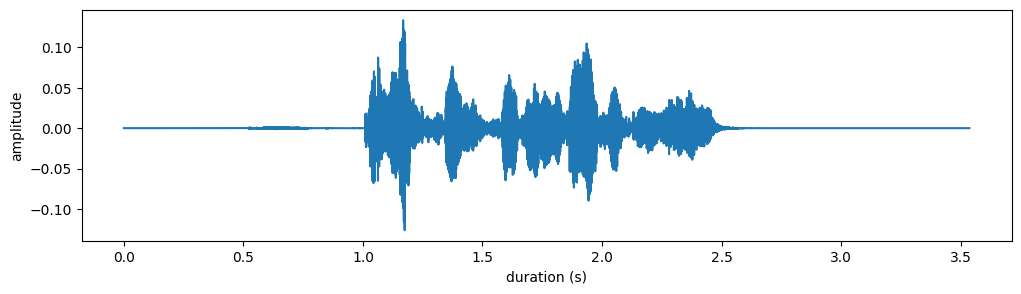



disgust sample:


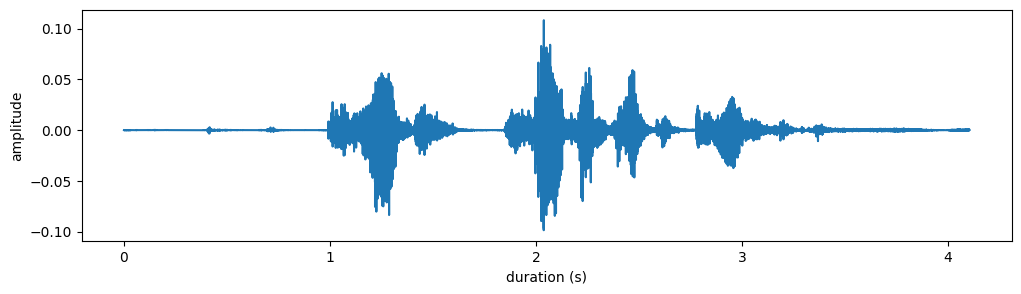



neutral sample:


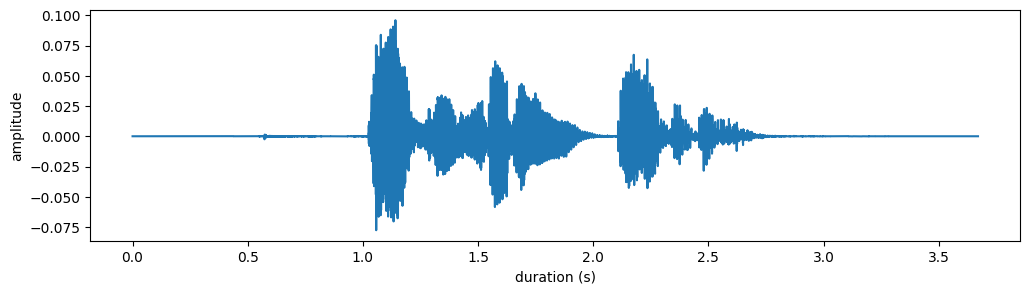



sad sample:


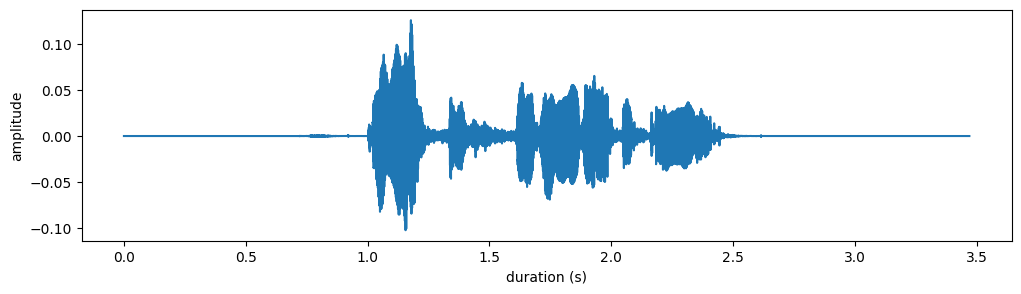



fearful sample:


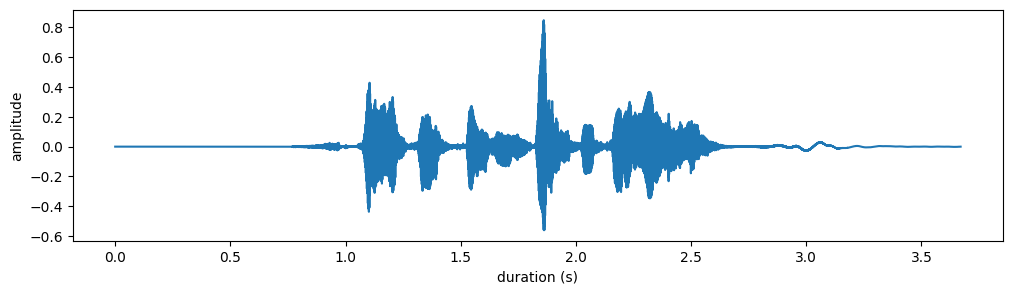



happy sample:


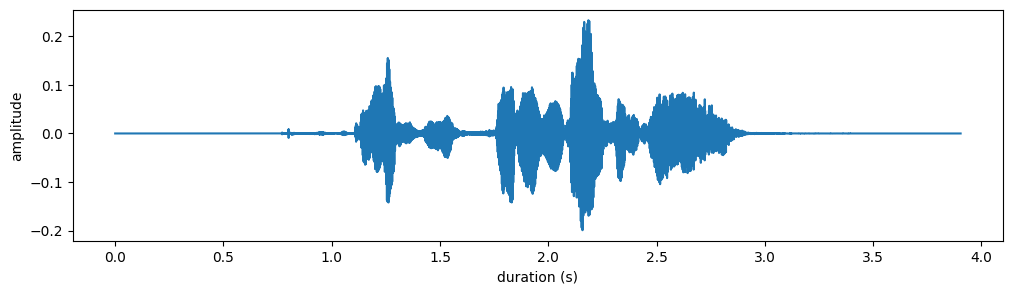

In [ ]:
# Plot a sample waveform for each emotion
take_audio_samples(ravdess_df)

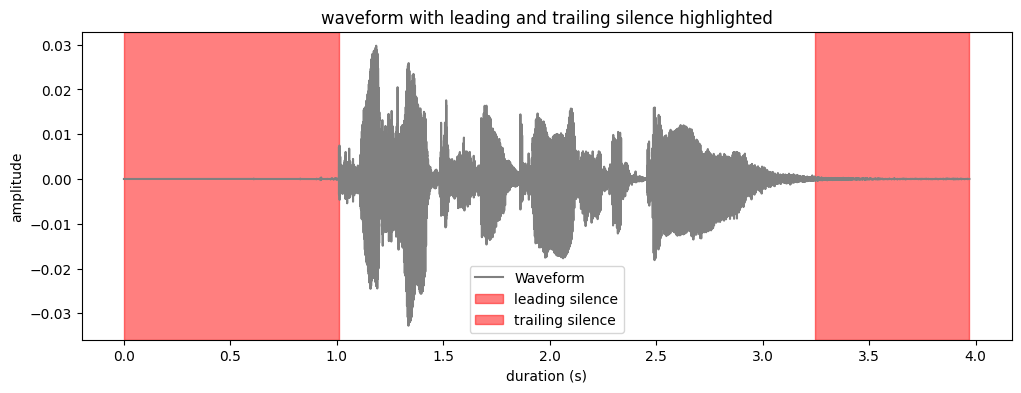

Original Audio:


Trimmed Audio:


In [ ]:
# Find where waveform is above threshold
sample = ravdess_df.sample(n=1).iloc[0]
waveform = sample["waveform"][0].numpy()
test_trim(waveform, 0.2, criteria="mean")

In [ ]:
# ravdess_df["waveform"] = ravdess_df["waveform"].apply(lambda a: trim_silence(a[0].numpy(), 0.2, criteria="mean"))

count      mean       std       min       25%       50%  \
clip durations  1440.0  2.147291  0.572436  1.123938  1.731969  2.053562   

                     75%       max  
clip durations  2.454594  4.440875

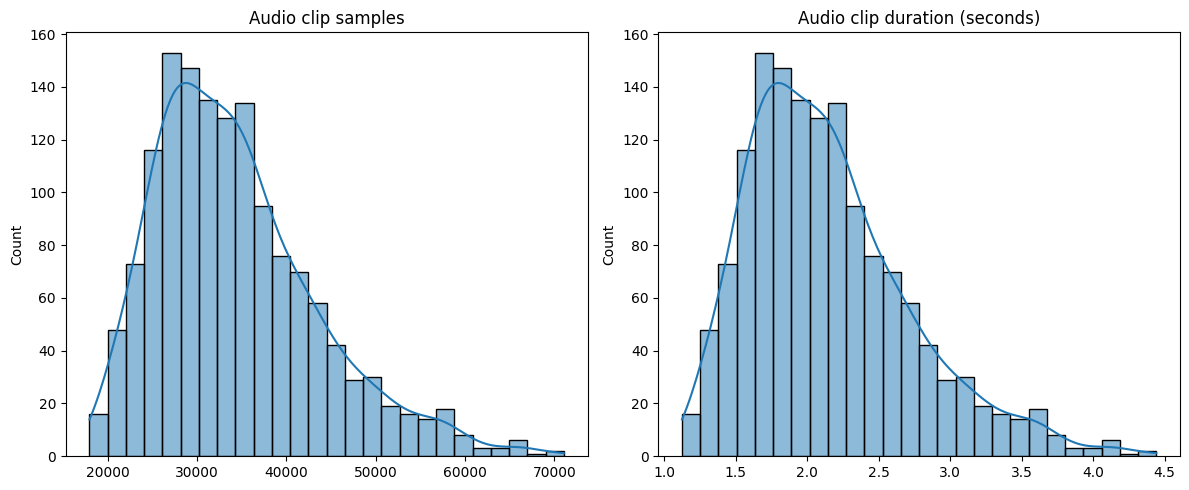

In [ ]:
# Examine distribution of clip lengths
audio_lengths = ravdess_df.apply(lambda a: a["waveform"].shape[1], axis=1)
plot_audio_lengths(audio_lengths)

surprised sample:


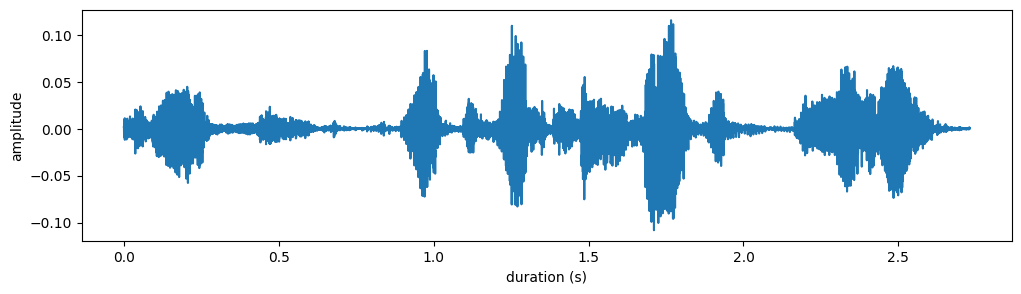



disgust sample:


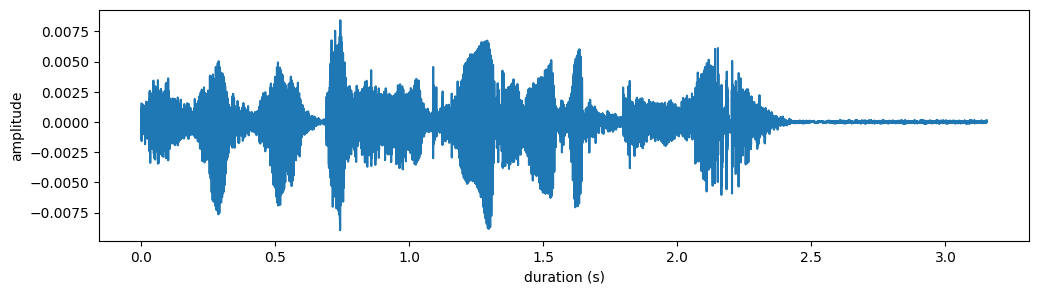



fearful sample:


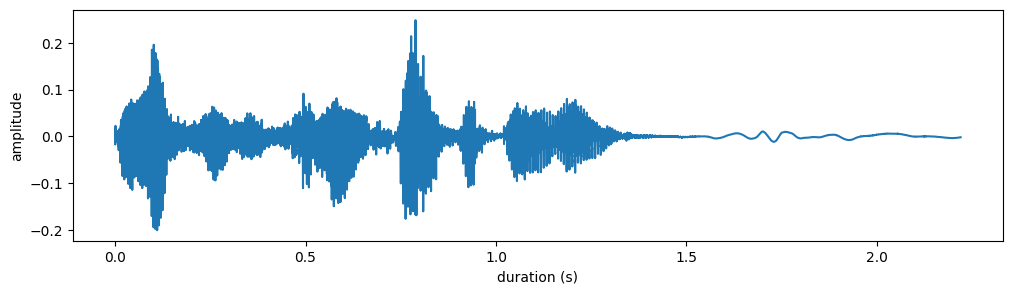



neutral sample:


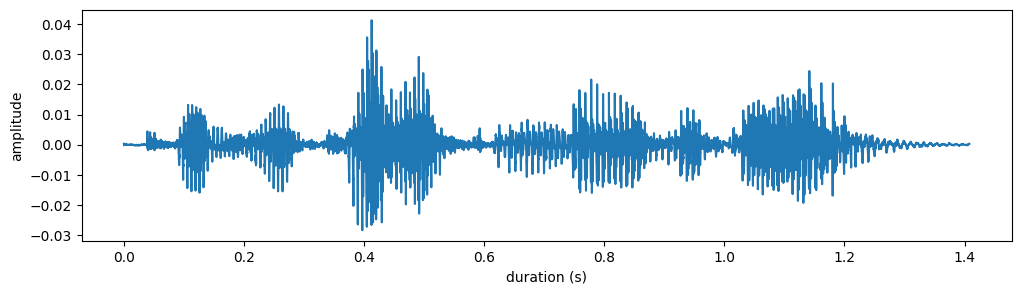



happy sample:


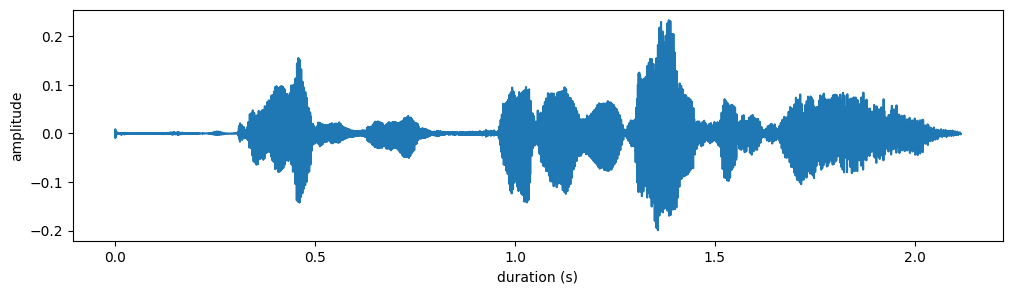



sad sample:


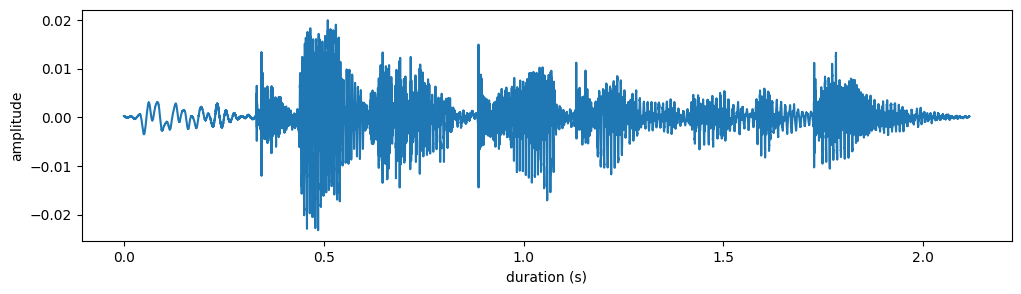



angry sample:


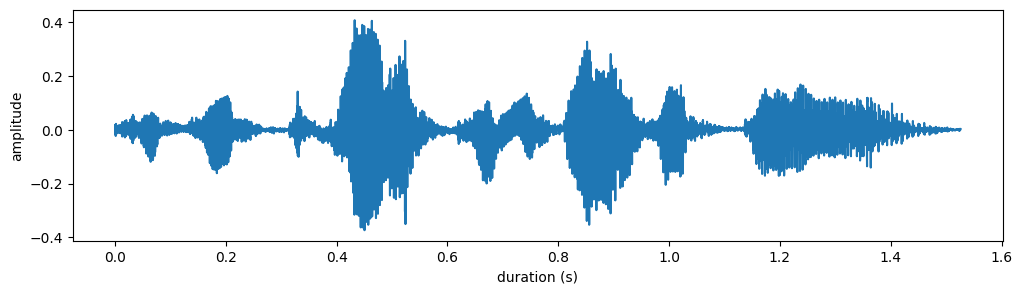

In [ ]:
# Plot a sample waveform for each emotion
take_audio_samples(ravdess_df)

### SAVEE

In [49]:
savee_dir = "/content/datasets/Savee"

# Set sample rate to 16 kHz
resample = torchaudio.transforms.Resample(orig_freq=44100, new_freq=SAMPLE_RATE)

# Prepare a list to hold data
savee_data = []

label_map = {
  "a": "angry",
  "d": "disgust",
  "f": "fearful",
  "h": "happy",
  "n": "neutral",
  "sa": "sad",
  "su": "surprised"
}

# For every audio file, parse metadata from the filename and load waveform
for file in os.listdir(savee_dir):
  # Metadata
  parts = file.split("_")[1].split(".")

  prefix = ""
  for c in parts[0]:
    if c.isalpha():
      prefix += c

  label = label_map[prefix]

  # Waveform
  file_path = os.path.join(savee_dir, file)
  waveform, sample_rate = torchaudio.load(file_path)

  # Downsample to 16 kHz
  waveform = resample(waveform)

  # Assemble row of data
  savee_data.append({
    "file_path": file_path,
    "emotion": label,
    "waveform": waveform,
    "length": waveform.shape[1]
  })

# Create dataframe
savee_df = pd.DataFrame(data=savee_data)
print(savee_df.info())
savee_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  480 non-null    object
 1   emotion    480 non-null    object
 2   waveform   480 non-null    object
 3   length     480 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 15.1+ KB
None


file_path    emotion  \
0   /content/datasets/Savee/JK_d06.wav    disgust   
1  /content/datasets/Savee/JE_su03.wav  surprised   
2   /content/datasets/Savee/KL_n20.wav    neutral   
3   /content/datasets/Savee/KL_n09.wav    neutral   
4   /content/datasets/Savee/DC_d12.wav    disgust   

                                            waveform  length  
0  [[tensor(0.0343), tensor(0.0542), tensor(0.048...   59707  
1  [[tensor(0.0104), tensor(0.0164), tensor(0.014...   46546  
2  [[tensor(0.0009), tensor(0.0014), tensor(0.001...   44986  
3  [[tensor(0.0008), tensor(0.0014), tensor(0.001...   53662  
4  [[tensor(0.0271), tensor(0.0426), tensor(0.038...   59539

emotion  neutral  angry  sad  disgust  surprised  fearful  happy
count        120     60   60       60         60       60     60

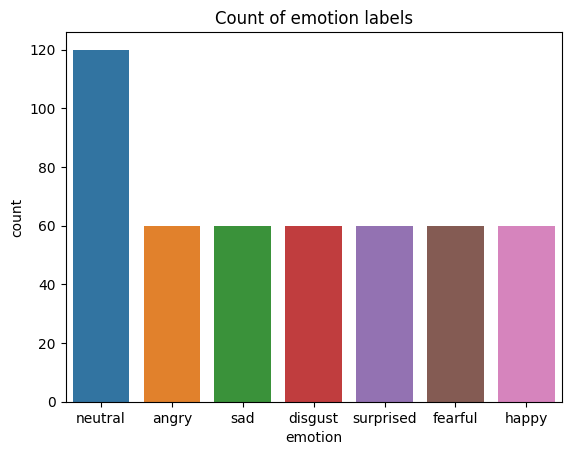

In [ ]:
# View distribution of emotion labels
display(savee_df["emotion"].value_counts().to_frame().T)

sns.barplot(
    data=savee_df["emotion"].value_counts().reset_index(),
    x="emotion",
    y="count",
    hue="emotion"
)

plt.title("Count of emotion labels")
plt.show()

count      mean       std       min       25%       50%  \
clip durations  480.0  3.839505  1.078021  1.630937  3.076562  3.673031   

                   75%      max  
clip durations  4.5185  7.13875

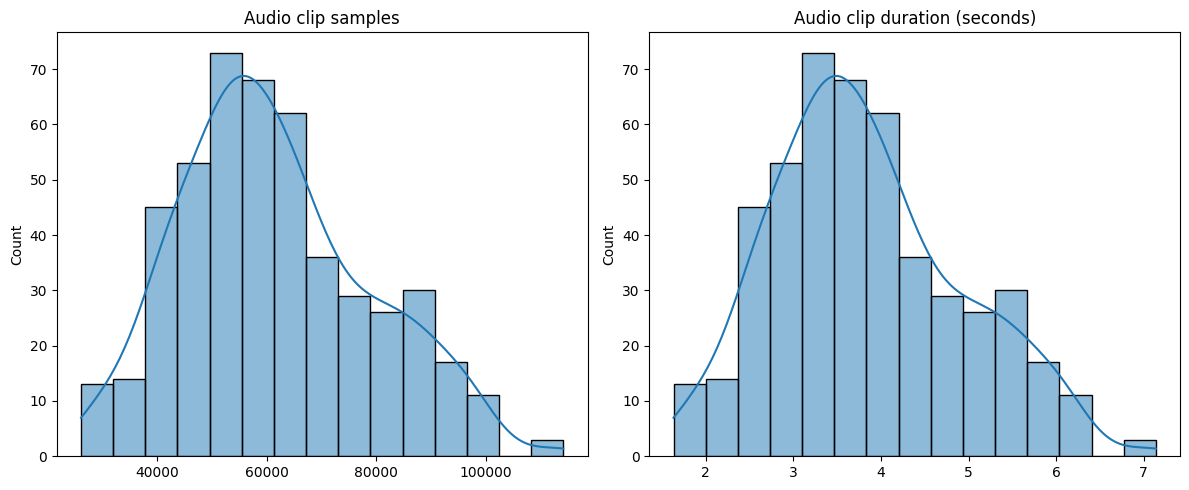

In [ ]:
# Examine distribution of clip lengths
audio_lengths = savee_df.apply(lambda a: a["waveform"].shape[1], axis=1)
plot_audio_lengths(audio_lengths)

sad sample:


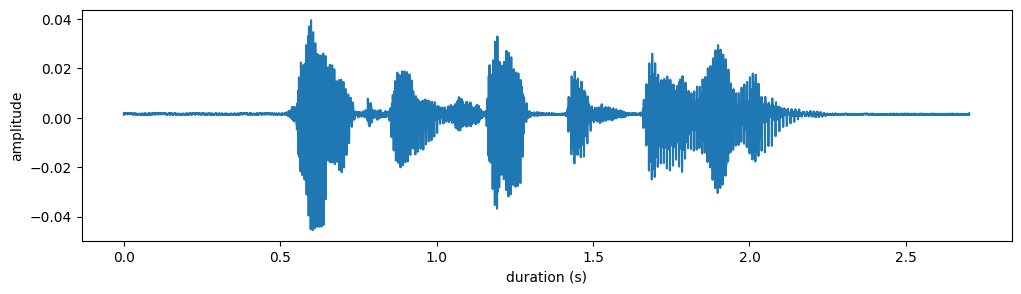



angry sample:


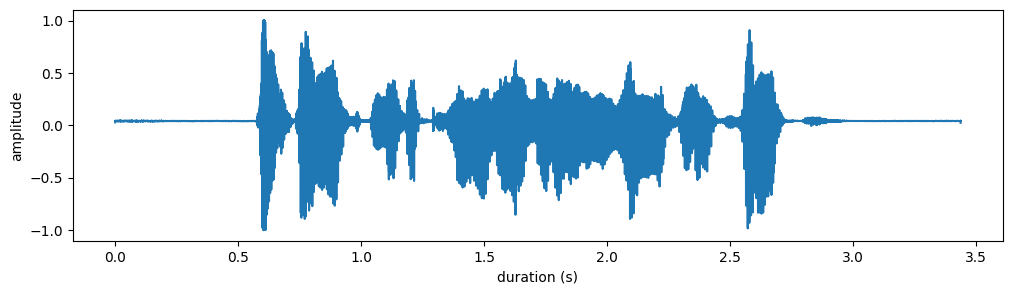



disgust sample:


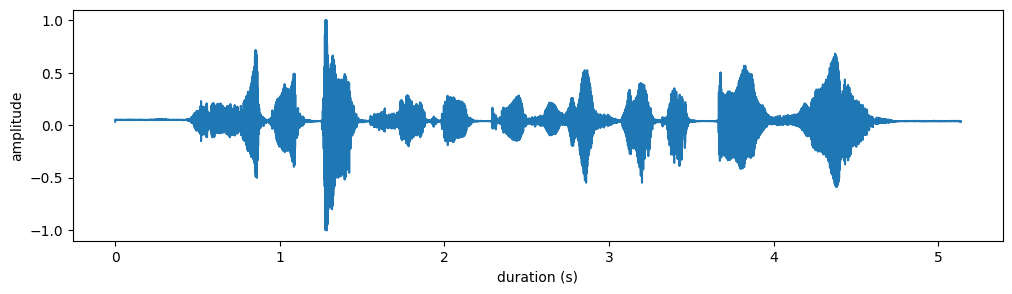



surprised sample:


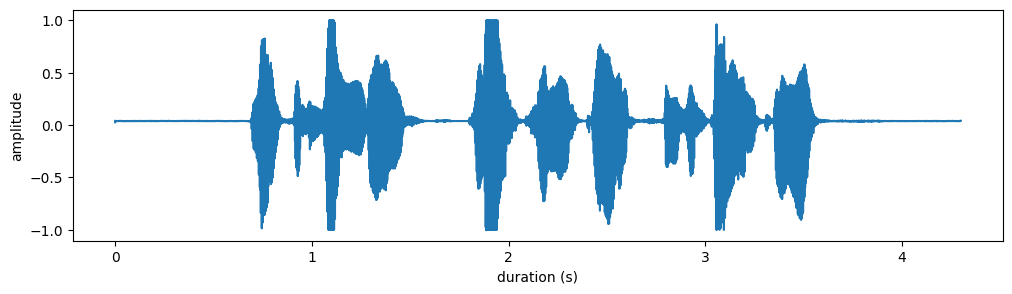



fearful sample:


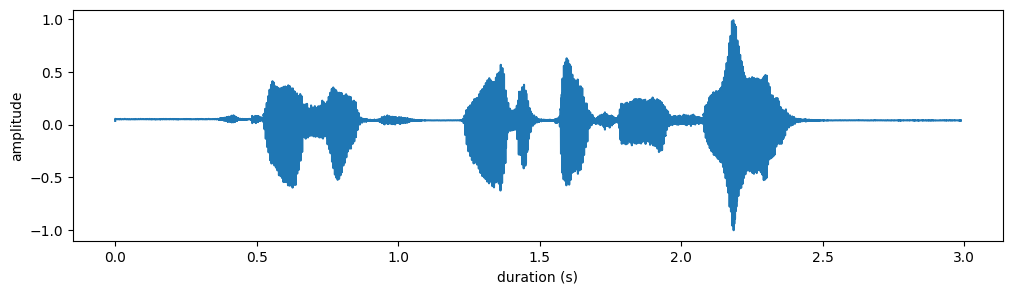



neutral sample:


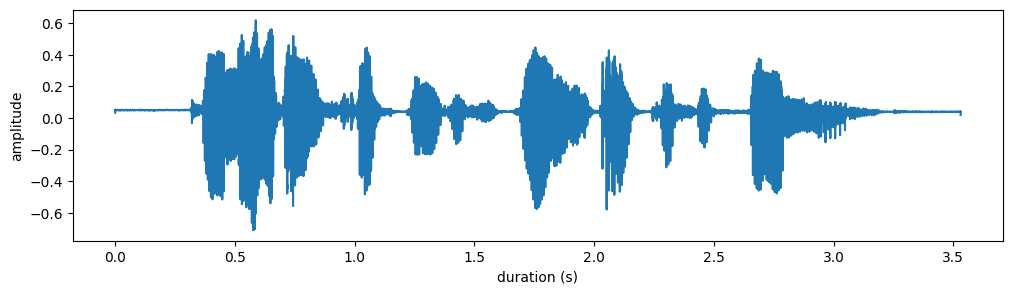



happy sample:


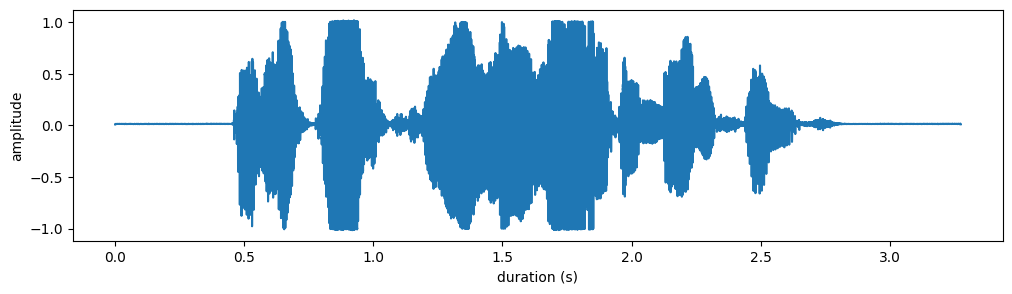

In [ ]:
# Plot a sample waveform for each emotion
take_audio_samples(savee_df)

### TESS

In [50]:
tess_dir = "/content/datasets/Tess"

# Set sample rate to 16 kHz
resample = torchaudio.transforms.Resample(orig_freq=24414, new_freq=SAMPLE_RATE)

# Prepare a list to hold data
tess_data = []

label_map = {
  "angry": "angry",
  "disgust": "disgust",
  "fear": "fearful",
  "happy": "happy",
  "neutral": "neutral",
  "sad": "sad",
  "ps": "surprised"
}

# For every audio file, parse metadata from the filename and load waveform
for dir in os.listdir(tess_dir):
  for file in os.listdir(os.path.join(tess_dir, dir)):
    parts = file.split(".")[0].split("_")
    label = label_map[parts[-1]]

    # Waveform
    file_path = os.path.join(tess_dir, dir, file)
    waveform, sample_rate = torchaudio.load(file_path)

    # Skip one waveform that has a different SR than the others
    if sample_rate != 24414:
      continue

    waveform = resample(waveform)

    # Assemble row of data
    tess_data.append({
      "file_path": file_path,
      "emotion": label,
      "waveform": waveform,
      "length": waveform.shape[1]
    })

# Create dataframe
tess_df = pd.DataFrame(data=tess_data)
print(tess_df.info())
tess_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2799 entries, 0 to 2798
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  2799 non-null   object
 1   emotion    2799 non-null   object
 2   waveform   2799 non-null   object
 3   length     2799 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 87.6+ KB
None


file_path emotion  \
0  /content/datasets/Tess/OAF_angry/OAF_tool_angr...   angry   
1  /content/datasets/Tess/OAF_angry/OAF_make_angr...   angry   
2  /content/datasets/Tess/OAF_angry/OAF_learn_ang...   angry   
3  /content/datasets/Tess/OAF_angry/OAF_hole_angr...   angry   
4  /content/datasets/Tess/OAF_angry/OAF_check_ang...   angry   

                                            waveform  length  
0  [[tensor(-1.7171e-05), tensor(-0.0001), tensor...   24148  
1  [[tensor(-1.5228e-06), tensor(-0.0001), tensor...   26134  
2  [[tensor(2.2964e-06), tensor(4.7695e-05), tens...   24254  
3  [[tensor(-2.7191e-05), tensor(-0.0002), tensor...   26727  
4  [[tensor(3.6586e-06), tensor(9.7278e-05), tens...   26339

emotion  angry  disgust  neutral  happy  sad  surprised  fearful
count      400      400      400    400  400        400      399

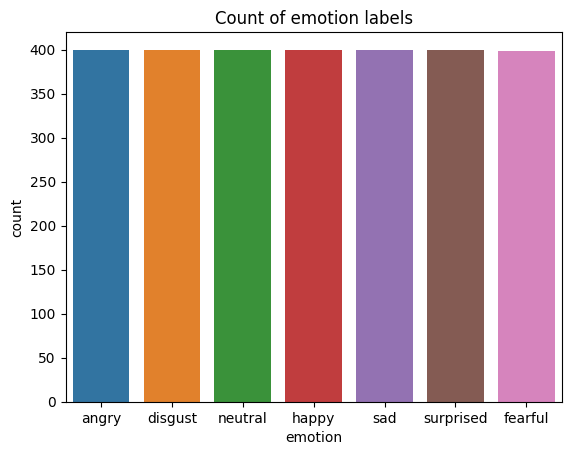

In [ ]:
# View distribution of emotion labels
display(tess_df["emotion"].value_counts().to_frame().T)

sns.barplot(
    data=tess_df["emotion"].value_counts().reset_index(),
    x="emotion",
    y="count",
    hue="emotion"
)

plt.title("Count of emotion labels")
plt.show()

count      mean       std       min       25%       50%  \
clip durations  2799.0  2.055351  0.320699  1.254125  1.836719  2.048313   

                     75%       max  
clip durations  2.277687  2.984812

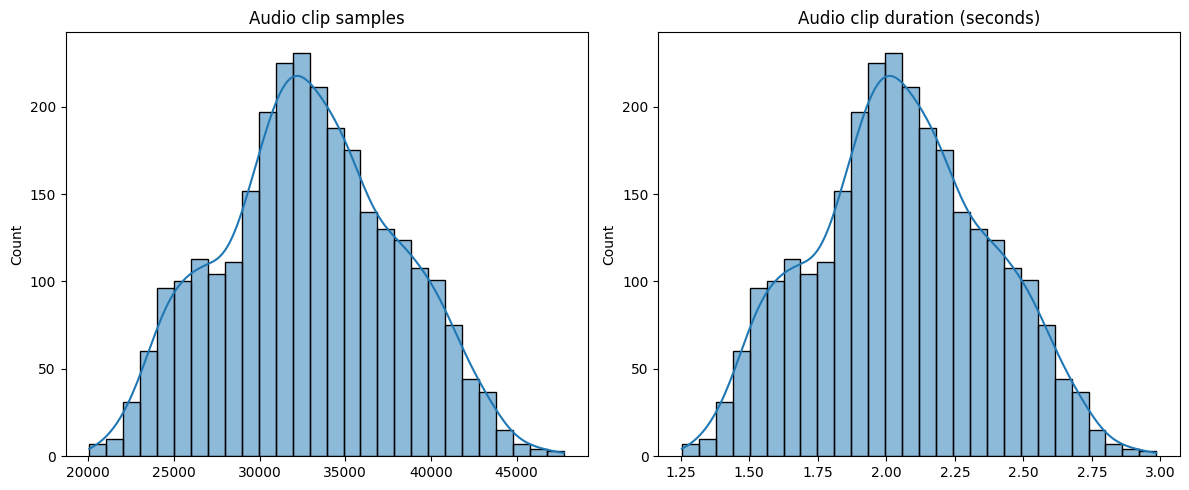

In [ ]:
# Examine distribution of clip lengths
audio_lengths = tess_df.apply(lambda a: a["waveform"].shape[1], axis=1)
plot_audio_lengths(audio_lengths)

angry sample:


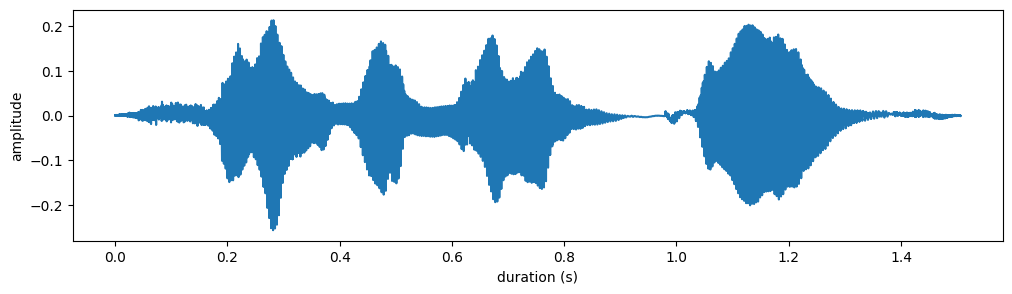



disgust sample:


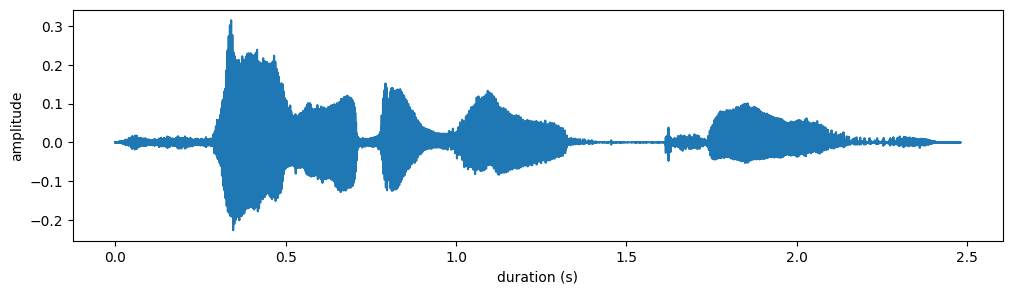



neutral sample:


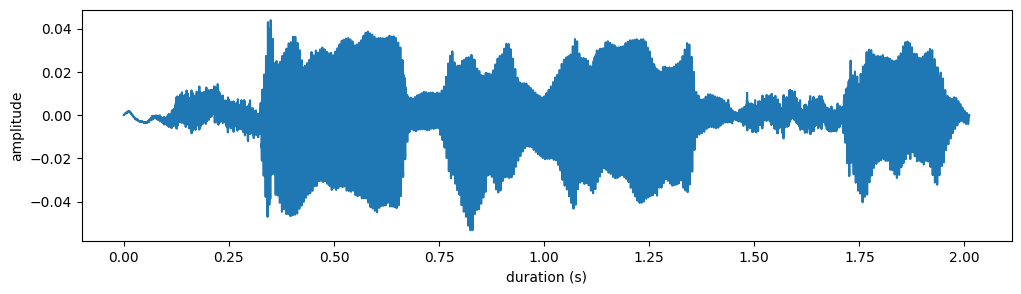



happy sample:


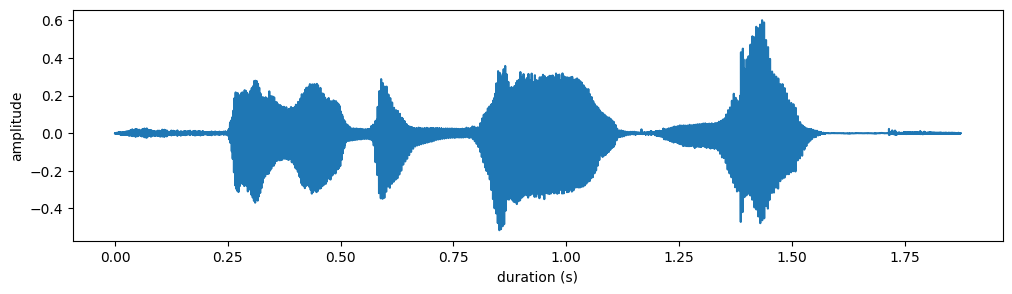



sad sample:


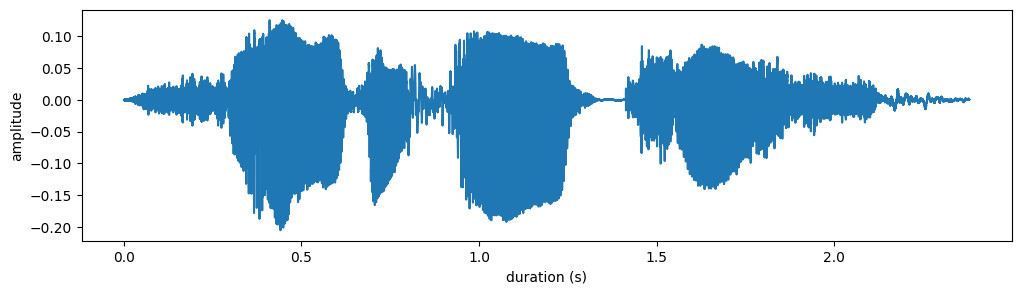



surprised sample:


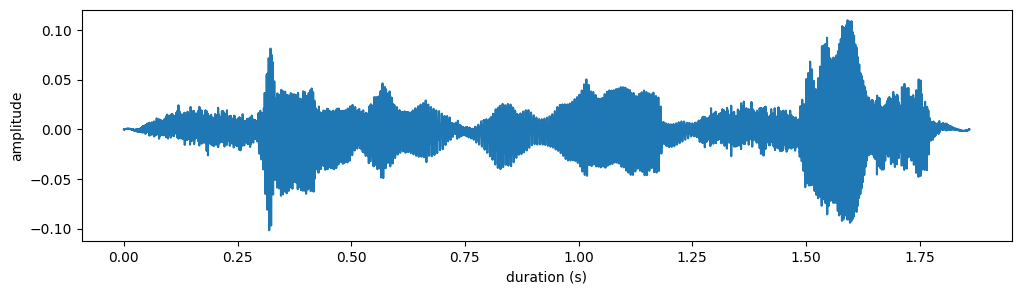



fearful sample:


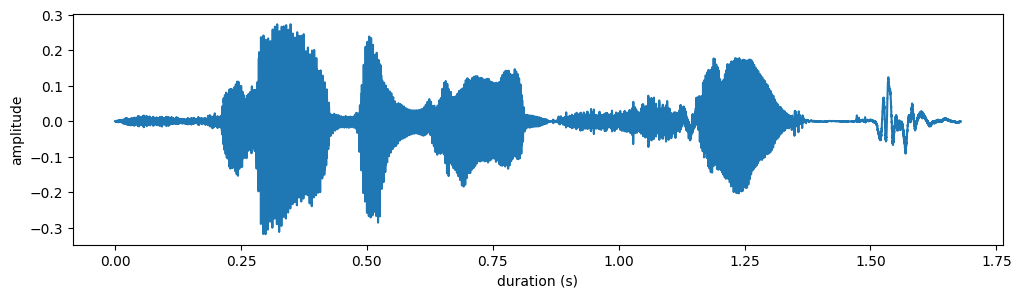

In [ ]:
# Plot a sample waveform for each emotion
take_audio_samples(tess_df)

## Training the model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12161 entries, 0 to 12160
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   emotion   12161 non-null  object
 1   waveform  12161 non-null  object
dtypes: object(2)
memory usage: 190.1+ KB
None


emotion  angry   sad  disgust  happy  fearful  neutral  surprised
count     1923  1923     1923   1923     1922     1895        652

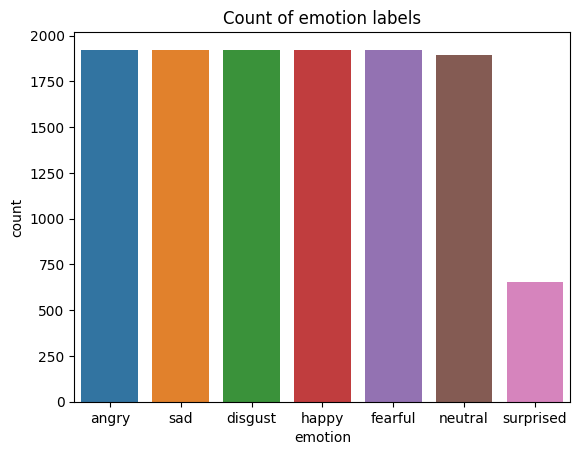

In [51]:
# Select columns for training and join all the data
cols = ["emotion", "waveform"]
processed_df = pd.concat([crema_df[cols], ravdess_df[cols], savee_df[cols], tess_df[cols]], axis=0).reset_index(drop=True)
print(processed_df.info())

# View distribution of emotion labels
display(processed_df["emotion"].value_counts().to_frame().T)

sns.barplot(
    data=processed_df["emotion"].value_counts().reset_index(),
    x="emotion",
    y="count",
    hue="emotion"
)

plt.title("Count of emotion labels")
plt.show()

In [52]:
# Split the dataset into train and test sets with a 90/10 split
train_df, test_df = train_test_split(processed_df, test_size=0.1, random_state=42)

In [53]:
# Split clips in the training set that are 3 seconds or longer
new_train_rows = []
old_train_rows = []

for i, row in train_df.iterrows():
  waveform = row["waveform"]
  length = waveform.shape[1]
  if length >= 3 * SAMPLE_RATE:
    # Split into two parts
    chunks = split_waveform(waveform)
    for i, chunk in enumerate(chunks):
      new_row = row.copy()
      new_row["waveform"] = chunk
      new_row["length"] = chunk.shape[1]
      new_train_rows.append(new_row)
  else:
    old_train_rows.append(row)

print(f"Added {len(new_train_rows)/2} new rows to the training set.")

# Add old rows to new rows and update training set
new_train_rows.extend(old_train_rows)
train_df = pd.DataFrame(new_train_rows)

# Do the same for the test set
new_test_rows = []
old_test_rows = []

for i, row in test_df.iterrows():
  waveform = row["waveform"]
  length = waveform.shape[1]
  if length >= 3 * SAMPLE_RATE:
    # Split into two parts
    chunks = split_waveform(waveform)
    for i, chunk in enumerate(chunks):
      new_row = row.copy()
      new_row["waveform"] = chunk
      new_row["length"] = chunk.shape[1]
      new_test_rows.append(new_row)
  else:
    old_test_rows.append(row)

print(f"Added {len(new_test_rows)/2} new rows to the test set.")

# Add old rows to new rows and update test set
new_test_rows.extend(old_test_rows)
test_df = pd.DataFrame(new_test_rows)

Added 2741.0 new rows to the training set.
Added 324.0 new rows to the test set.


count      mean       std       min       25%       50%  \
clip durations  13690.0  2.092475  0.399494  1.254125  1.768438  2.033125   

                     75%       max  
clip durations  2.402375  3.512437

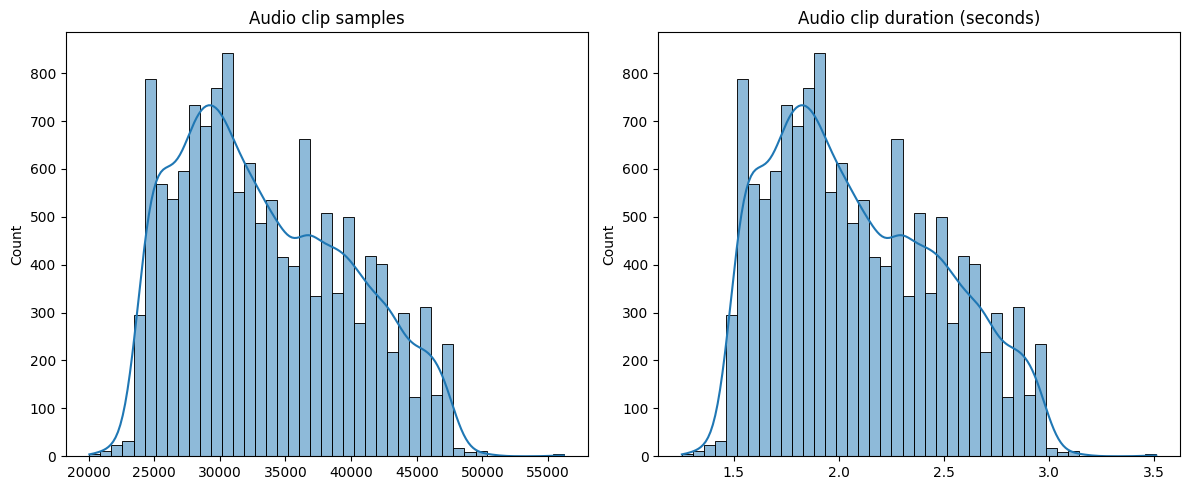

count      mean       std       min      25%       50%  \
clip durations  1536.0  2.085306  0.403306  1.267937  1.75175  2.018687   

                     75%       max  
clip durations  2.369063  3.569375

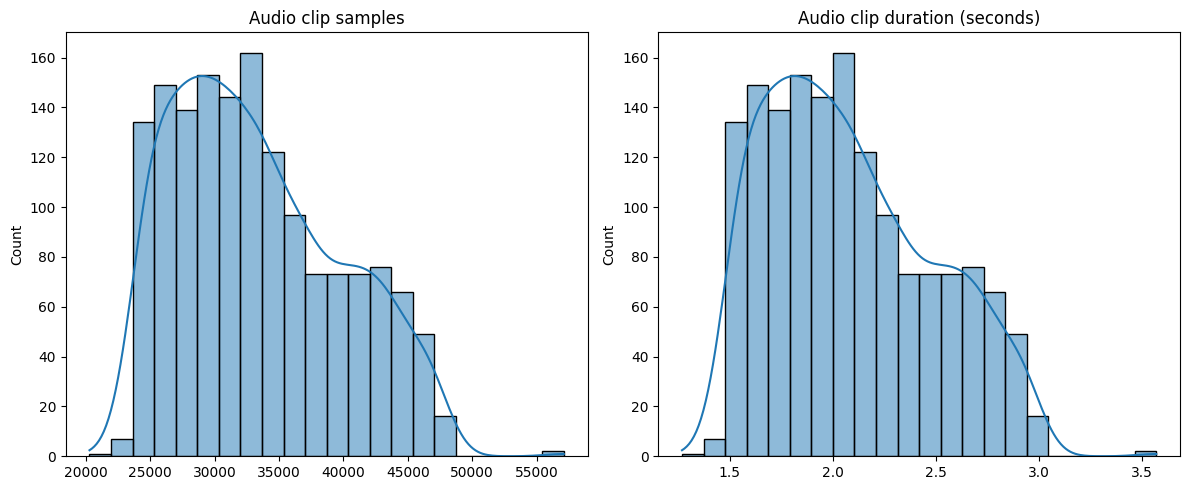

In [ ]:
# Examine distribution of clip lengths
train_audio_lengths = train_df.apply(lambda a: a["waveform"].shape[1], axis=1)
plot_audio_lengths(train_audio_lengths)

test_audio_lengths = test_df.apply(lambda a: a["waveform"].shape[1], axis=1)
plot_audio_lengths(test_audio_lengths)

In [54]:
# Define label to/from integer mappings
emotion_to_idx = {
    "happy": 0,
    "fearful": 1,
    "surprised": 2,
    "neutral": 3,
    "disgust": 4,
    "sad": 5,
    "angry": 6
}
idx_to_emotion = {
    0: "happy",
    1: "fearful",
    2: "surprised",
    3: "neutral",
    4: "disgust",
    5: "sad",
    6: "angry"
}

NUM_CLASSES = 7
train_df["emotion"] = train_df["emotion"].map(emotion_to_idx)
test_df["emotion"] = test_df["emotion"].map(emotion_to_idx)

In [ ]:
# AUGMENT = Compose([
#     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
#     PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
# ])

In [55]:
# Create torch dataset
class SERDataset(Dataset):
  def __init__(self, data):
    self.data = data
    # 2 second windows
    self.target_length = SAMPLE_RATE * 2

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    waveform = self.data.iloc[idx]["waveform"]
    label = self.data.iloc[idx]["emotion"]

    # Pad/truncate waveform to target length
    waveform = self.pad_or_truncate(waveform)

    # Squeeze shape to (frames,) and perform z score normalization
    waveform = waveform.squeeze(0)
    mean = waveform.mean()
    std = waveform.std()
    normalized = (waveform - mean) / (std + 1e-5)

    # Unsqueeze back to (1, frames)
    input_values = normalized.unsqueeze(0)
    return {"input_values": input_values.squeeze(0), "labels": label}

  # Helper function for padding/truncation
  def pad_or_truncate(self, waveform):
    current_length = waveform.shape[-1]
    if current_length > self.target_length:
      # Truncate
      waveform = waveform[..., :self.target_length]
    elif current_length < self.target_length:
      # Pad at the end
      pad_size = self.target_length - current_length
      waveform = torch.nn.functional.pad(waveform, (0, pad_size))
    return waveform

In [56]:
# Create datasets
train_dataset = SERDataset(train_df)
test_dataset = SERDataset(test_df)

In [ ]:
# Dowload pretrained Wav2Vec2 and processor
pretrained_model_name = "facebook/wav2vec2-base"
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels=NUM_CLASSES,
    problem_type="single_label_classification"
)

# Override classifier
model.classifier = nn.Sequential(
  nn.LayerNorm(256),
  nn.Dropout(0.3),
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Dropout(0.3),
  nn.Linear(128, NUM_CLASSES)
)

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Helper function for additional metrics to log during training
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
# Configure HF Trainer
batch_size = 16
training_args = TrainingArguments(
  output_dir="wav2vec2-finetuned-ser",
  learning_rate=3e-5,
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  num_train_epochs=20,
  weight_decay=0.02,
  eval_strategy="epoch",
  save_strategy="epoch",
  logging_strategy="epoch",
  load_best_model_at_end=True,
  report_to="none"
)

trainer = Trainer(
  model=model,
  args=training_args,
  compute_metrics=compute_metrics,
  train_dataset=train_dataset,
  eval_dataset=test_dataset,
  callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()

TrainOutput(global_step=5136, training_loss=0.6744721492874288, metrics={'train_runtime': 631.4691, 'train_samples_per_second': 433.592, 'train_steps_per_second': 27.111, 'total_flos': 1.49197077853056e+18, 'train_loss': 0.6744721492874288, 'epoch': 6.0})

TrainOutput(global_step=5334, training_loss=0.6519490868847693, metrics={'train_runtime': 688.45, 'train_samples_per_second': 353.984, 'train_steps_per_second': 22.137, 'total_flos': 1.54927742335968e+18, 'train_loss': 0.6519490868847693, 'epoch': 7.0})

              precision    recall  f1-score   support

       happy       0.84      0.73      0.78       241
     fearful       0.75      0.71      0.73       221
   surprised       0.79      0.92      0.85        73
     neutral       0.82      0.89      0.85       262
     disgust       0.84      0.74      0.79       248
         sad       0.66      0.76      0.71       238
       angry       0.89      0.90      0.89       253

    accuracy                           0.80      1536
   macro avg       0.80      0.81      0.80      1536
weighted avg       0.80      0.80      0.80      1536



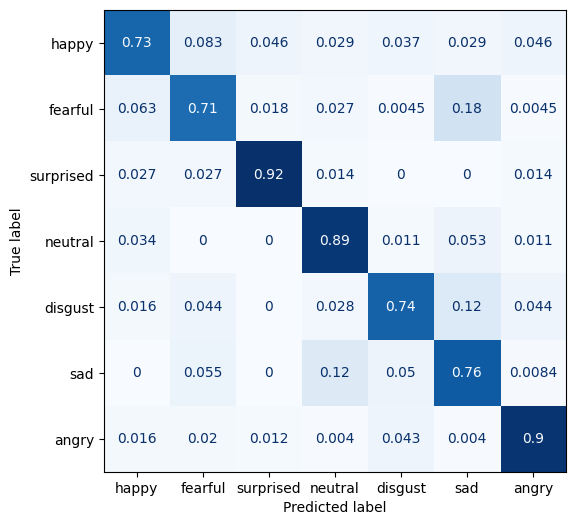

In [ ]:
# Generate predictions for test dataset
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = predictions.label_ids

# Evaluate
print(classification_report(y_true, y_pred, target_names=emotion_to_idx))
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_to_idx.keys()))
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.show()

## Exporting the model

In [ ]:
!pip install onnx onnxruntime onnxruntime-tools onnxconverter_common

In [58]:
from torch.utils.data import DataLoader
import onnx
import onnxruntime as ort
from onnxconverter_common import float16

In [ ]:
# Save the model and check its size
trainer.save_model("./wav2vec2-finetuned-ser")

model_path = "/content/wav2vec2-finetuned-ser/model.safetensors"
size_bytes = os.path.getsize(model_path)
size_megabytes = size_bytes / (1024 * 1024)

print(f"Model size: {size_megabytes:.2f} MB")

Model size: 360.91 MB


In [ ]:
# Export model as ONNX
# Move model to CPU first
model = model.cpu()

# Force float32 everywhere
for param in model.parameters():
    param.data = param.data.float()
for buffer in model.buffers():
    buffer.data = buffer.data.float()

# Create dummy input tensor for input/output shape
dummy_input = torch.randn(1, 32000, dtype=torch.float32)

# Export
torch.onnx.export(
    model,
    dummy_input,
    "SER_fp32.onnx",
    input_names=["input_values"],
    output_names=["logits"],
    opset_version=14,
    dynamic_axes={
        "input_values": {0: "batch_size", 1: "sequence_length"},
        "logits": {0: "batch_size"}
    }
)

/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:870: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz, self.num_heads, tgt_len, self.head_dim):


In [27]:
# Check that model exported correctly
# Create a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=8)

# Load ONNX runtime inference session for the model
onnx_model = ort.InferenceSession("SER_fp32.onnx", providers=["CPUExecutionProvider"])

# Run ONNX model on the test set
all_preds = []
all_labels = []
for batch in test_loader:
    input_values = batch["input_values"].numpy()
    labels = batch["labels"].numpy()

    inputs = {onnx_model.get_inputs()[0].name: input_values}
    outputs = onnx_model.run(None, inputs)

    logits = outputs[0]
    preds = np.argmax(logits, axis=-1)

    all_preds.append(preds)
    all_labels.append(labels)

# Stack everything
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

# Evaluate
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       225
           1       0.85      0.81      0.83       234
           2       0.90      0.91      0.91        82
           3       0.89      0.97      0.93       245
           4       0.91      0.83      0.87       273
           5       0.75      0.85      0.80       229
           6       0.95      0.95      0.95       253

    accuracy                           0.88      1541
   macro avg       0.89      0.89      0.89      1541
weighted avg       0.89      0.88      0.88      1541



In [ ]:
# Reduce precision to 16-bit floating point
model_fp32 = onnx.load("/content/SER_fp32.onnx")
model_fp16 = float16.convert_float_to_float16(model_fp32)
onnx.save(model_fp16, "/content/SER_fp16.onnx")

In [59]:
# Check the size of the reduced precision model
model_fp16_path = "/content/SER_fp16.onnx"
size_bytes = os.path.getsize(model_fp16_path)
size_megabytes = size_bytes / (1024 * 1024)

print(f"Model size: {size_megabytes:.2f} MB")

Model size: 180.81 MB


In [29]:
# Check that fp16 model exported correctly
# Create a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=8)

# Load ONNX runtime inference session for the fp16 model
onnx_model = ort.InferenceSession("SER_fp16.onnx", providers=["CPUExecutionProvider"])

# Run ONNX model on the test set
all_preds = []
all_labels = []
for batch in test_loader:
    input_values = batch["input_values"].numpy().astype(np.float16)
    labels = batch["labels"].numpy()

    inputs = {onnx_model.get_inputs()[0].name: input_values}
    outputs = onnx_model.run(None, inputs)

    logits = outputs[0]
    preds = np.argmax(logits, axis=-1)

    all_preds.append(preds)
    all_labels.append(labels)

# Stack everything
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

# Evaluate
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       225
           1       0.85      0.81      0.83       234
           2       0.90      0.91      0.91        82
           3       0.89      0.97      0.93       245
           4       0.91      0.83      0.87       273
           5       0.75      0.85      0.80       229
           6       0.95      0.95      0.95       253

    accuracy                           0.88      1541
   macro avg       0.89      0.89      0.89      1541
weighted avg       0.89      0.88      0.88      1541

